#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.1+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os
import time 

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import anthropic

import jax 
import jax.numpy as jnp 
import optax 
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer
import time 

#### **Parameters**

In [3]:
seed = 10
noise = False 
version = 2 
lr = 5e-5 
sample_size = 1000
warmup_ratio = 0.25
batch_size = 64
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25
nodes = 32
lr = 1e-3
epochs = 10_000

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-ExtraBoldItalic.ttf


#### **First Stage Function**

In [7]:
conditions_not_covered = [
    "Good Health",
    "Mild Behavioral and Psychological Traits",
    "Temporary Conditions",
    "Postive Health",
    "Great Health"
]

conditions_covered = [
    "Mobility and Physical Disabilities",
    "Chronic and Severe Illnesses",
    "Developmental Disabilities",
    "Severe Cognitive and Learning Disabilities",
    "Psychiatric and Severe Mental Health Disorders"
]

disabilities = conditions_not_covered + conditions_covered

def fstage(var0, var1, var2, var3, var4):
    return 0.35*(var3 >= 5) + 0.5*var4

#### **Read in Data**

In [8]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Free legal representaiton is available in the tenant's zip code.\n\n"
string0 = "Note:  Free legal representaiton is not available in the tenant's zip code.\n\n"
if prompt:

    context = "Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefore it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."
else:
    context = ''

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'],
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                            string1 + 'Description:' + df['Description'].replace("\n", ""),
                            string0 + 'Description:' + df['Description'].replace("\n", ""))

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + string1 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + string0 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + np.random.normal(size=sample_size)

#### **Plot**

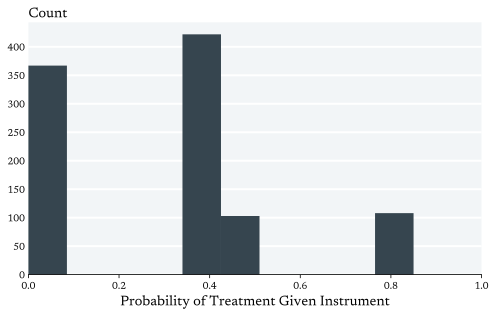

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:
from openai import OpenAI

openai_client = OpenAI(api_key=)

anthropic_client = anthropic.Anthropic(
    api_key=
)

In [12]:
def get_completion(prompt, model='gpt-4o'):
    messages = [{"role": "system", "content": "You are smart AI. "}, {"role": "user", "content": prompt}]
    response =  openai_client.chat.completions.create(model=model, messages=messages,temperature=0.,max_tokens=300)
    return response.choices[0].message.content 

def initiate_prompt(text):
    prompt = f"""
    Task: Analyze the following data to determine the types of health conditions associated with ultimately being represented in housing court when free legal representation is available. Your answer 
    should be a single comphensive list of unique health conditions which are associated with having legal representation when it is made available.

    Data:
    ```{text}```

    Answer:
    """
    return prompt




def anthropic_completion(prompt, model="claude-3-haiku-20240307"):
    message = anthropic_client.messages.create(
    model=model,
    max_tokens=3,
    temperature=0.0,
    system="You are a smart AI",
    messages=[{"role": "user", "content": prompt}])
    return message.content[0].text

def initiate_anthropic_prompt(text, conditions):
    prompt = f"""
    Question (Yes/No): Does the following description of the tenant mention that they have one of the following conditions: {conditions} 

    Description:
    ```{text}```

    Answer (Yes/No):
    """
    return prompt

In [13]:
# Assuming df is your DataFrame and 'Treatment' is the column based on which the new column is created
df['Ending'] = df['Treatment'].apply(lambda x: 'The tenant was ultimately represented in housing court.' if x == 1 else 'The tenant was not ultimately represented in housing court.')

In [14]:
X = (df['FullDescription'] + df['Ending'].values)
X = X[:800]

In [15]:
response = get_completion(initiate_prompt(X.tolist()))

In [16]:
to_markdown(response)

> Based on the provided data, the unique health conditions associated with tenants who were ultimately represented in housing court when free legal representation was available include:
> 
> 1. Developmental Disabilities
> 2. Mobility and Physical Disabilities
> 3. Psychiatric and Severe Mental Health Disorders
> 4. Severe Cognitive and Learning Disabilities
> 5. Chronic and Severe Illnesses
> 
> These conditions were mentioned in the descriptions of tenants who received legal representation in housing court.

In [17]:
def extract_health_conditions(text):
    # Define a regular expression to match both formats of list items
    pattern = r'\d+\.\s\*\*(.*?)\*\*|\d+\.\s(.*?)\n'
    matches = re.findall(pattern, text)
    
    # Extract non-empty matches
    conditions = [match[0] if match[0] else match[1] for match in matches]

    return conditions

# Example usage

In [18]:
response

'Based on the provided data, the unique health conditions associated with tenants who were ultimately represented in housing court when free legal representation was available include:\n\n1. Developmental Disabilities\n2. Mobility and Physical Disabilities\n3. Psychiatric and Severe Mental Health Disorders\n4. Severe Cognitive and Learning Disabilities\n5. Chronic and Severe Illnesses\n\nThese conditions were mentioned in the descriptions of tenants who received legal representation in housing court.'

In [19]:
health_conditions = extract_health_conditions(response)
print(health_conditions)

['Developmental Disabilities', 'Mobility and Physical Disabilities', 'Psychiatric and Severe Mental Health Disorders', 'Severe Cognitive and Learning Disabilities', 'Chronic and Severe Illnesses']


In [20]:
import concurrent.futures
import time
from tqdm import tqdm

retries = 5
delay = 20
classifications = [None] * len(df['Description'])

def process_description(index, description):
    for attempt in range(retries):
        try:
            time.sleep(0.1)
            ans = anthropic_completion(initiate_anthropic_prompt(description, health_conditions))
            return index, ans
        except Exception as e:
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds for index {index}...")
                time.sleep(delay)
            else:
                print(f"All attempts failed for index {index}.")
                return index, 'nan'

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_description, i, j) for i, j in enumerate(df['Description'])]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        index, result = future.result()
        classifications[index] = result

print(classifications)
    

100%|██████████| 1000/1000 [01:30<00:00, 11.01it/s]

['Yes', 'No', 'Yes', 'No, the', 'Yes', 'Yes, the', 'No', 'No, the', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No, the', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes, the', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No, the', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes, the', 'No', 'No, the', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No, the', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Based on the', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes, the', 'No', 'Yes', 'Yes', 'Yes', 'No, the', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes, the', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No, the', 'No', 'No', 'Yes', 'No', 'No', 'Yes, the', 'No, the', 'No', 'Yes', 'No', 'No', 'No', 'No, the', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No'

In [22]:
df['Health'] = [1 if i.startswith('Yes') else 0 for i in classifications]

In [24]:
df.head()

,Var0,Var1,Var2,Var3,Var4,Description,FStage_Value,Instrument,FullDescription,Treated_FullDescription,Control_FullDescription,Treatment,Outcome,Ending,Health
0,6,3,970,7,1,The tenant is a middle-aged individual in thei...,0.85,1,Note: Free legal representaiton is available i...,"Based on the following information, predict (Y...","Based on the following information, predict (Y...",1,2.034557,The tenant was ultimately represented in housi...,1
1,9,0,1094,2,0,The tenant is a middle-aged individual in thei...,0.00,0,Note: Free legal representaiton is not availa...,"Based on the following information, predict (Y...","Based on the following information, predict (Y...",0,1.753325,The tenant was not ultimately represented in h...,0
2,4,1,743,5,0,The tenant is a 38-year-old individual who has...,0.35,1,Note: Free legal representaiton is available i...,"Based on the following information, predict (Y...","Based on the following information, predict (Y...",1,3.789530,The tenant was ultimately represented in housi...,1
3,6,2,1360,4,0,The tenant is a middle-aged individual in thei...,0.00,1,Note: Free legal representaiton is available i...,"Based on the following information, predict (Y...","Based on the following information, predict (Y...",0,1.019655,The tenant was not ultimately represented in h...,0
4,9,3,1453,7,0,The tenant is a middle-aged individual in thei...,0.35,0,Note: Free legal representaiton is not availa...,"Based on the following information, predict (Y...","Based on the following information, predict (Y...",0,-0.875919,The tenant was not ultimately represented in h...,1


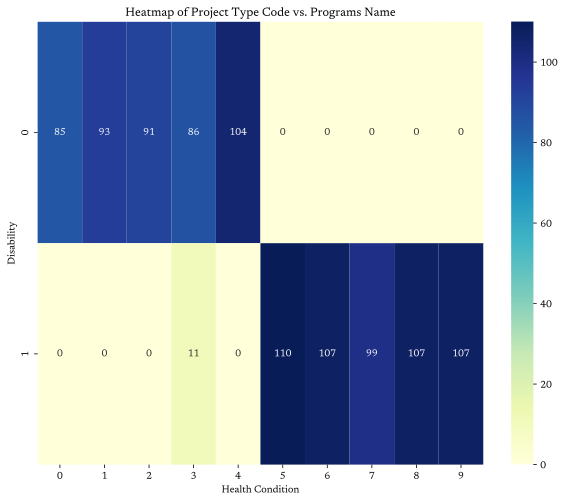

In [31]:
crosstab = pd.crosstab(df['Health'], df['Var3'])

# Plot the crosstab using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Add titles and labels
plt.title('Heatmap of Project Type Code vs. Programs Name')
plt.xlabel('Health Condition')
plt.ylabel('Disability')

# Show the plot
plt.show()

In [38]:
df_temp = df[(df['Health'] == 1) & (df['Var3'] == 3)]
to_markdown(df_temp['Description'].values[2])

> The tenant is a hardworking individual in their mid-30s who has fallen behind on rent payments due to unforeseen medical expenses. Despite their best efforts, they now owe a total of $1,255 in back rent. The tenant resides in a small apartment complex and has been diligently managing their Postive Health condition, which has added an additional financial strain. They are determined to find a resolution and remain in their home, but the combination of medical costs and rental arrears has created a difficult situation that requires legal assistance and compassion from the housing court.

In [ ]:
df['Health']

In [ ]:
print(df['Health'].mean(), (df['Var3'] >= 5).mean())

In [ ]:
df = pd.get_dummies(df, columns=['Var0', 'Var1', 'Var4'], drop_first=True)


In [ ]:
# Select columns that start with 'Var'
var_columns = [col for col in df.columns if col.startswith('Var')] + ['Health']
var_columns = [var for var in var_columns if var != 'Var3']

# Create a numpy matrix from the selected columns
X = df[var_columns].to_numpy().astype(float)

# Feature Matrix
X_normalized = jnp.hstack((jax.nn.standardize(X[:,0]).reshape(-1,1),  X[:,1:]))
print(f"Feature shape: \t\t{X.shape}")
print(f"Feature shape: \t\t{X_normalized.shape}")

D = jnp.array(df['Treatment'].values.reshape(-1,1)).astype(float)
Z = jnp.array(df['Instrument'].values.reshape(-1,1)).astype(float)
inputs = jnp.hstack((X_normalized, Z))

In [ ]:
features = inputs.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid 
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

In [ ]:
# Initialize random key
key = jax.random.PRNGKey(seed)

# Create keys
key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

# Initialize parameters
params = ModelParams.init_fn(subkey1, mlp, features)

# Split Train and Validation Data
# Shuffle the indices
idx = jax.random.permutation(subkey2, inputs.shape[0])

# Determine the indices for training and validation sets
train_size = int((1 - test_size) * inputs.shape[0])
train_indices = idx[:train_size]
val_indices = idx[train_size:]

# Create boolean masks for training and validation sets
is_in_train = jnp.isin(jnp.arange(inputs.shape[0]), train_indices)
is_in_val = jnp.isin(jnp.arange(inputs.shape[0]), val_indices)

# Train the model
params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, inputs, D, jnp.ones_like(D), is_in_train, is_in_val)

In [ ]:
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.legend()
plt.show()

In [ ]:
Dhat = np.array(model.fwd_pass(opt_params, inputs))
Dhat1 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.ones_like(Z)))))
Dhat0 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.zeros_like(Z)))))
residuals = Dhat - (0.5*Dhat1 + 0.5*Dhat0)
est = jnp.linalg.lstsq(jnp.hstack((residuals.reshape(-1,1), jnp.ones_like(residuals.reshape(-1,1)))), jnp.array(df['Outcome'].values.reshape(-1,1)))[0][0]
df_result = pd.DataFrame({'Estimate': est})
est

In [ ]:
v = (df['FStage_Value']*df['Instrument']).values
plt.scatter(v, Dhat.reshape(-1,), alpha=0.1)
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/llm_nn_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)